## (SKIP) Utilities

In [1]:
n_fft = 512 # 512 better for speech and 2048 (default) better for music, this should probably be a hyper-parameter
hop_length = n_fft // 2

In [2]:
def show_spectrogram(spectrogram, sample_rate, title=None, ax=None):
    oimg = librosa.display.specshow(spectrogram, sr=sample_rate, x_axis="time", y_axis="log", ax=ax, hop_length=hop_length)
    if title:
        ax.set(title=title) if ax else plt.set(title=title)
    plt.colorbar(oimg, ax=ax, format="%+2.f dB")

# Clean Audio Pipeline

This notebook defines the pipeline to train the clean audio model.  

This is a simple pipeline that takes audio files and creates higher quality audio files.  
To achieve this we need some intermediate steps.  

To simplify the solution, we use a state-of-the-art image architecture, so most of the work goes into treating audio as images.  
Our pipeline thus have some conversion steps:  
```Audio -> Spectrogram -> Featurise -> Model -> Spectrogram -> Audio```

## TODO

- [ ] Convert this code into FastAI

## Setup environment

In [21]:
# Only set this up once!!!

# Download models
!wget -P models/ https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128_512_upsampler.pt

# Download model module
# TODO: Set this up as a git submodule
!mkdir thirdparty
!git clone https://github.com/openai/guided-diffusion.git thirdparty/guided-diffusion

--2022-06-04 19:38:50--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128_512_upsampler.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.150.77.132
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.150.77.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235462529 (1.2G) [application/octet-stream]
Saving to: ‘models/128_512_upsampler.pt.1’

128_512_upsampler.p   8%[>                   ] 103.43M  6.92MB/s    eta 2m 22s ^C
mkdir: cannot create directory ‘thirdparty’: File exists
fatal: destination path 'thirdparty/guided-diffusion' already exists and is not an empty directory.


In [ ]:
%env WORK_PATH=data/train_clean_audio/
WORK_PATH="data/train_clean_audio/"

## Load and Convert Audio to Spectrogram

Let's start by setting up the environment.

In [26]:
import librosa
import librosa.display
import numpy as np

import matplotlib.pyplot as plt

We can now add support for loading `wav` files and converting them to spectrograms, using `librosa`.  
For more about Mel Spectrograms, I found this interesting article on Medium https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

In [111]:
def to_spectrogram(audio, sample_rate):
    """Converts wave information into the mel spectrogram representation.
    Returns the spectrogram and reference value used to normalise.
    """
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
    # Changes to log scale (dB) and normalises considering the maximum value
    return librosa.power_to_db(melspectrogram, ref=np.max), np.max(melspectrogram)

Since we're here, we'll also create a simple function to convert the spectrogram back to audio. Doing it here helps keeping in sync.  

In [112]:
def to_audio(melspectrogram, sample_rate, reference):
    """Converts mel spectrograms into wave form.
    Returns the wave data and sample_rate (to keep audio representations consistent).
    """
    audio = librosa.db_to_power(melspectrogram, ref=reference)
    return librosa.feature.inverse.mel_to_audio(audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length), sample_rate

Let's try it out by loading a wav file and showing the spectrogram.

In [113]:
audio, sample_rate = librosa.load("data/audio/synth_voice.wav")
spectrogram, ref = to_spectrogram(audio, sample_rate)
original_shape = spectrogram.shape
original_shape

(128, 140)

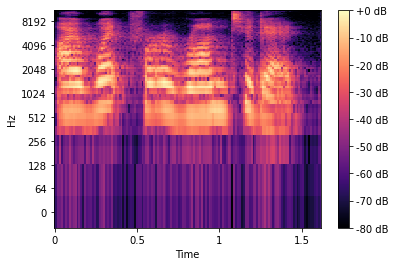

In [114]:
show_spectrogram(spectrogram, sample_rate)

## Featurise the Spectrograms

The upsampling model we're going to run takes 128x128 images, so we first have to convert our spectrograms into images of the right size.    
To avoid stretching the audio, we have to split it into chunks of 128 based on the spectrogram resolution.  

For now we're going to assume all audio files have the same length.  
In the case an audio file is shorter than the minimum chunk size, we will have to experiment with different transformations (e.g. padding vs stretching).  

Spectrograms are 2D arrays representing frequency aggregation by time (1 channel, negative float values).  
Our model consumes RGB values (3 channels, int values).  

The images our model takes are still represented as numpy arrays, and we're going to keep them that way.  

In [92]:
import PIL.Image
from IPython.display import Image

In [93]:
def featurise(melspectrogram, size):
    spec_image = PIL.Image.fromarray((-melspectrogram).astype("int32"))
    spec_image = spec_image.resize(size)
    return np.asarray(spec_image.convert("RGB"))

In [94]:
def from_featurised(melspectrogram_image, size):
    spec = PIL.Image.fromarray(melspectrogram_image)
    if size:
        spec = spec.resize(reversed(size))
    spec = spec.convert("I")
    return -np.asarray(spec)

Let's see how it looks like.

In [129]:
spectrogram_image = featurise(spectrogram, (128, 128))

#### Quick Check the image makes sense

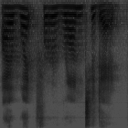

In [130]:
PIL.Image.fromarray(spectrogram_image).show()

In [97]:
spectrogram_image.shape

(128, 128, 3)

### Let's save the input dataset

The dataset consists of a list of images (N, 64, 64, 3) and a corresponding list of labels (N).  
We don't care for the labels in the case of prediction and they're just a list of 0s.

In [15]:
np.savez(WORK_PATH + "in_128_dataset.npz", np.array([spectrogram_image]), [0])

## Upscaling using our Model

We are now ready to use the model.

### Setup the model environment

In [16]:
!pip install mpi4py
!pip install -e thirdparty/guided-diffusion/.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.5 MB 23.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp38-cp38-linux_x86_64.whl size=6021261 sha256=beda502fba2ab8f30e091094e2074ae1ad163a73cebb435aad894604a1365520
  Stored in directory: /tmp/pip-ephem-wheel-cache-krou_id5/wheels/aa/c1/3d/9d4f406c1cefee8cefec7ac511a3147cd6cc39412b27bb5bc5
Successfully built mpi4py
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///notebooks/thirdparty/guided-diffusion
     |████████████████████████████████| 70 kB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 50.5 MB/s eta 0:00:01
  Running setup.py develop for guided-diffusion


In [17]:
%env SAMPLE_FLAGS=--batch_size 4 --num_samples 10 --timestep_respacing 250
%env MODEL_FLAGS=--attention_resolutions 32,16 --class_cond True --diffusion_steps 1000 --large_size 512 --small_size 128 --learn_sigma True --noise_schedule linear --num_channels 192 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True

env: SAMPLE_FLAGS=--batch_size 4 --num_samples 10 --timestep_respacing 250
env: MODEL_FLAGS=--attention_resolutions 32,16 --class_cond True --diffusion_steps 1000 --large_size 512 --small_size 128 --learn_sigma True --noise_schedule linear --num_channels 192 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True


### Run the model and copy the results

The model runs and outputs to a temp folder, copy the results.

In [18]:
!python thirdparty/guided-diffusion/scripts/super_res_sample.py ${MODEL_FLAGS} --model_path models/128_512_upsampler.pt ${SAMPLE_FLAGS} --base_samples ${WORK_PATH}in_128_dataset.npz

Logging to /tmp/openai-2022-06-04-17-46-35-371127
creating model...
loading data...
creating samples...
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3784: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
created 4 samples
created 8 samples
created 12 samples
saving to /tmp/openai-2022-06-04-17-46-35-371127/samples_10x512x512x3.npz
sampling complete


In [19]:
!cp /tmp/openai-2022-06-04-17-46-35-371127/*.npz ${WORK_PATH}out_512_samples.npz

### Load the results

In [131]:
output_file = np.load(WORK_PATH + "out_512_samples.npz")
with output_file as output_data:
    output_spectrogram_image = output_data["arr_0"][0]

upscaled_spectrogram = from_featurised(output_spectrogram_image, size=original_shape)
upscaled_spectrogram.shape

(128, 140)

## Analysing the Results

The original audio has been converted into a spectrogram and upscaled. Let's now analyse the results in the various formats.

### Compare Spectrograms

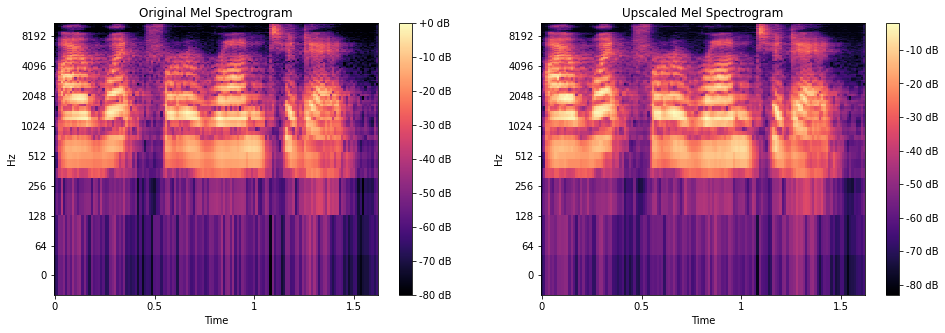

In [122]:
_, (oax, uax) = plt.subplots(1, 2, figsize=(16, 5))

# Original spectrogram
show_spectrogram(spectrogram, sample_rate, title="Original Mel Spectrogram", ax=oax)

# Upscaled spectrogram
show_spectrogram(upscaled_spectrogram, sample_rate, title="Upscaled Mel Spectrogram", ax=uax)

#### Important notes and conclusion

The upscalling model seems to blur some of the details. It's possible this approach isn't ideal for discrete values.  
Another issue is with the conversion between dB floats and RGB since we're essentially discarding information. Maybe we could use each channel to encode part of the float.

### Compare Audio Waves

Ok, so we have done our magic in Spectrogram space. Let's convert it back to a wave form.

In [123]:
original_audio, sample_rate = to_audio(spectrogram, sample_rate, ref)
converted_audio, sample_rate = to_audio(upscaled_spectrogram, sample_rate, ref)

[Text(0.5, 1.0, 'Upscaled Wave')]

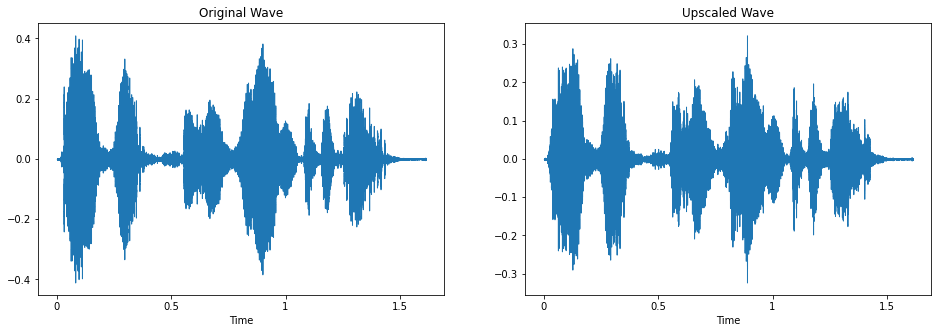

In [124]:
fig, (oax, uax) = plt.subplots(1, 2, figsize=(16, 5))

# Original wave
librosa.display.waveshow(audio, ax=oax)
oax.set(title="Original Wave")

# Upscaled wave
librosa.display.waveshow(converted_audio, ax=uax)
uax.set(title="Upscaled Wave")

In [125]:
from IPython.display import Audio
import soundfile as sf

#### Original

In [126]:
sf.write("data/train_clean_audio/original.wav", original_audio, sample_rate)
Audio(original_audio, rate=sample_rate)

#### Upscaled

In [127]:
sf.write("data/train_clean_audio/upscaled.wav", converted_audio, sample_rate)
Audio(converted_audio, rate=sample_rate)